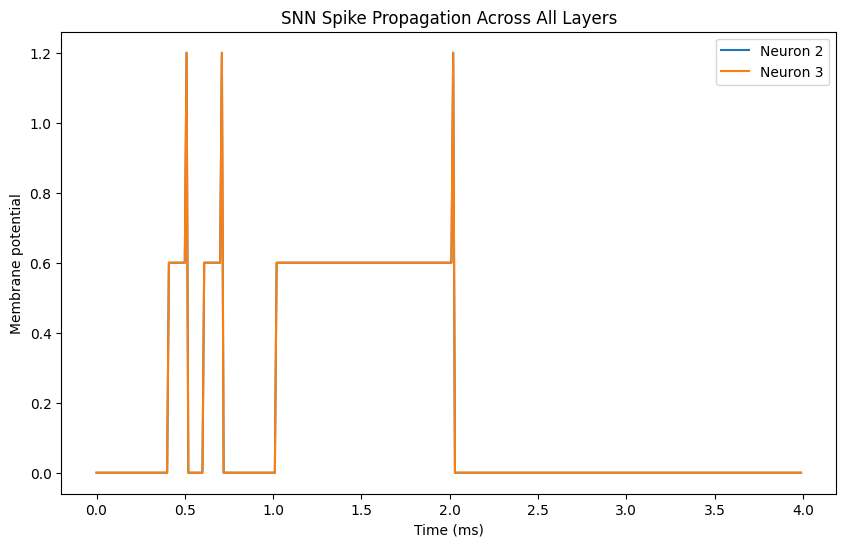

Neuron 0 spike times: ['1.010 ms']
Neuron 1 spike times: ['2.010 ms']
Neuron 2 spike times: ['0.510 ms', '0.710 ms', '2.020 ms']


In [34]:
# V0.2 connecting to make 2 inputs and 2 outputs for Ygg

# V0.1 Single Neruon for Yggrasil for spiking inputs and tau

from brian2 import *
import numpy as np
import logging, warnings

start_scope()

defaultclock.dt = 0.01*ms  

#prefs.codegen.target = 'cython'
set_device('runtime')
warnings.filterwarnings('ignore', category=RuntimeWarning)  # check error later
np.seterr(over='ignore', under='ignore')
logging.getLogger('brian2').setLevel(logging.ERROR)




@implementation('numpy', discard_units=True)
@check_units(global_clock=1, tau_fire_time=1, spikes_fired=1, result=1)
def tau_fire(spikes_fired, tau_fire_time, global_clock):
    '''0 when not at tau time + fired_time 1 when it is v +=1.2 when it is true'''
    if spikes_fired == 2: 
        if global_clock > tau_fire_time - 0.01:  # can change the - to other value of time_steps
            return 1
    return 0

def Ygg_2nd_layer(inputs, taus):


    neurons = NeuronGroup(4, '''
            v : 1
            global_clock : 1
            spikes_fired : 1
            tau_fire_time : 1   
        ''', threshold='v > 1', reset='''
            v = 0
            spikes_fired += 1
        ''', method='exact') 
    neurons.v = 0.0
    neurons.spikes_fired = 0
    neurons.tau_fire_time = 4 # should be runtime to start 
    #neurons[2:].threshold = 2

    stim = SpikeGeneratorGroup(2, indices=[0,1], times= inputs * ms)


    syn_input = Synapses(stim, neurons[0:2], '''
    ''', on_pre='''
        v += 1.2
    ''')
    syn_input.connect(j='i') 



    # might need to change synapcies inputs to differnt 2:4 or somthnig
    syn_hidden = Synapses(neurons[0:2], neurons[2:4], '''
    ''', on_pre='''
        v += 0.6
    ''')
    syn_hidden.connect() 

    stim_tau_hidden = SpikeGeneratorGroup(4, indices=[2,2,3,3], times = taus * ms)

    syn_tau_hidden = Synapses(stim_tau_hidden, neurons[2:4], '''
    ''', on_pre='''
        v += 0.6
    ''')

    syn_tau_hidden.connect()

    #yn_hidden_tau.delay[:] = taus * ms

#v += (tau_fire(spikes_fired, tau_fire_time, global_clock) * 1.2)

    neurons.run_regularly('''
        global_clock += 0.01
    ''', dt=0.01*ms)

    mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
    spikemon = SpikeMonitor(neurons)

    run(4*ms)

    # Plot v
    figure(figsize=(10, 6))
    for i in range(2, 4): 
        plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
    xlabel('Time (ms)')
    ylabel('Membrane potential')
    legend()
    title('SNN Spike Propagation Across All Layers')
    show()

    for i in range(0,3):
        times = spikemon.spike_trains()[i]
        if len(times) > 0:
            formatted_times = [f"{t/ms:.3f} ms" for t in times]
            print(f"Neuron {i} spike times: {formatted_times}")



inputs = [1.0, 2.0]
taus = [0.4, 0.5, 0.6, 0.7] # will test by changing and seeing result later
# assuming 2x2 here

Ygg_2nd_layer(inputs, taus)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import ipywidgets as widgets
# from IPython.display import display, clear_output

# def simulate(spike_times, tau=20.0, dt=0.1, V_thr=1.5, T=100.0):
#     """Simulate a leaky integrator and return voltage trace and firing time."""
#     time = np.arange(0, T + dt, dt)
#     v = np.zeros_like(time)
#     fire_time = None
#     spike_idx = [int(t / dt) for t in spike_times]
#     for i in range(1, len(time)):
#         # constant leak: dv/dt = -v/tau
#         v[i] = v[i-1] + (-v[i-1]/tau)*dt
#         # inject spikes
#         if i in spike_idx:
#             v[i] += 1.0
#         # check threshold
#         if fire_time is None and v[i] >= V_thr:
#             fire_time = time[i]
#     return time, v, fire_time

# def update_plot(t1, t2, t3):
#     spike_times = [t1, t2, t3]
#     var = np.var(spike_times)
#     time, v, fire_time = simulate(spike_times)
    
#     clear_output(wait=True)
#     fig, ax = plt.subplots(figsize=(8,4))
#     ax.plot(time, v, label='Membrane potential')
#     ax.axhline(1.0, color='r', linestyle='--', label='Threshold')
#     for t in spike_times:
#         ax.axvline(t, color='gray', linestyle=':')
#     if fire_time is not None:
#         ax.axvline(fire_time, color='magenta', linestyle='-', label=f'Firing @ {fire_time:.1f} ms')
#     ax.set_xlabel('Time (ms)')
#     ax.set_ylabel('Voltage')
#     ax.set_title(f'Input variance = {var:.3f} ms²')
#     ax.legend(loc='upper right')
#     plt.show()

# # Create sliders for three spike times
# slider1 = widgets.FloatSlider(description='Spike 1 (ms)', min=0, max=100, step=0.1, value=20.0)
# slider2 = widgets.FloatSlider(description='Spike 2 (ms)', min=0, max=100, step=0.1, value=50.0)
# slider3 = widgets.FloatSlider(description='Spike 3 (ms)', min=0, max=100, step=0.1, value=80.0)

# ui = widgets.VBox([slider1, slider2, slider3])
# out = widgets.interactive_output(update_plot, {
#     't1': slider1, 't2': slider2, 't3': slider3
# })

# display(ui, out)


Output()

In [ ]:
# from brian2 import *
# import numpy as np
# import matplotlib.pyplot as plt

# def Ygg_2nd_layer(inputs, taus):
#     start_scope()
#     defaultclock.dt = 0.01*ms

#     # 4 neurons: 0–1 hidden, 2–3 output
#     neurons = NeuronGroup(4, 'v : 1',
#                          threshold='v > 1',
#                          reset='v = 0',
#                          method='exact')
#     neurons.v = 0

#     # input spike train
#     stim = SpikeGeneratorGroup(2, indices=[0, 1], times=inputs * ms)

#     # --- INPUT → HIDDEN synapses ---
#     tau_in = np.array(taus[:2]) * ms

#     syn_input_fast = Synapses(stim, neurons[0:2], 'tau: second',
#                               on_pre='v_post += 1.2')
#     syn_input_fast.connect(j='i')
#     syn_input_fast.tau = tau_in

#     syn_input_slow = Synapses(stim, neurons[0:2], 'tau: second',
#                               on_pre='v_post += 1.2')
#     syn_input_slow.connect(j='i')
#     syn_input_slow.tau   = tau_in
#     syn_input_slow.delay = tau_in

#     # --- HIDDEN → OUTPUT synapses ---
#     # repeat each hidden tau for its two outgoing synapses
#     tau_hidden = np.repeat(np.array(taus[2:]), 2) * ms  # e.g. [1.3,1.3,1.4,1.4] ms

#     syn_hidden_fast = Synapses(neurons[0:2], neurons[2:4], 'tau: second',
#                                on_pre='v_post += 1.2')
#     syn_hidden_fast.connect()
#     syn_hidden_fast.tau = tau_hidden

#     syn_hidden_slow = Synapses(neurons[0:2], neurons[2:4], 'tau: second',
#                                on_pre='v_post += 1.2')
#     syn_hidden_slow.connect()
#     syn_hidden_slow.tau   = tau_hidden
#     syn_hidden_slow.delay = tau_hidden

#     # --- MONITORS ---
#     mon_hidden = StateMonitor(neurons, 'v', record=[0,2], dt=0.01*ms)
#     mon_output = StateMonitor(neurons, 'v', record=[2,4], dt=0.01*ms)
#     sp_input  = SpikeMonitor(stim)
#     sp_hidden = SpikeMonitor(neurons[0:2])
#     sp_output = SpikeMonitor(neurons[2:4])

#     run(4*ms)

#     # Plot hidden-layer voltages
#     plt.figure(figsize=(8,3))
#     for i in [0,1]:
#         plt.plot(mon_hidden.t/ms, mon_hidden.v[i], label=f'hidden {i}')
#     plt.xlabel('Time (ms)'); plt.ylabel('v'); plt.legend()
#     plt.title('Hidden-layer membrane potentials')
#     plt.show()

#     # Plot output-layer voltages
#     plt.figure(figsize=(8,3))
#     for i in [2,3]:
#         plt.plot(mon_output.t/ms, mon_output.v[i], label=f'output {i}')
#     plt.xlabel('Time (ms)'); plt.ylabel('v'); plt.legend()
#     plt.title('Output-layer membrane potentials')
#     plt.show()

#     # Print spike times
#     print("Input spikes:  ", {i: [f"{t/ms:.2f} ms" for t in sp_input.spike_trains()[i]]
#                                for i in sp_input.i})
#     print("Hidden spikes: ", {i: [f"{t/ms:.2f} ms" for t in sp_hidden.spike_trains()[i]]
#                                for i in sp_hidden.i})
#     print("Output spikes: ", {i: [f"{t/ms:.2f} ms" for t in sp_output.spike_trains()[i]]
#                                for i in sp_output.i})

# # example run
# inputs = [1.2, 2.3]         # ms
# taus   = [1, 1.2, 1.3, 1.4] # [to hidden0, hidden1, out2, out3] in ms
# Ygg_2nd_layer(inputs, taus)


IndexError: The indices to record from contain values outside of the range [0, 3] allowed for the group 'neurongroup'

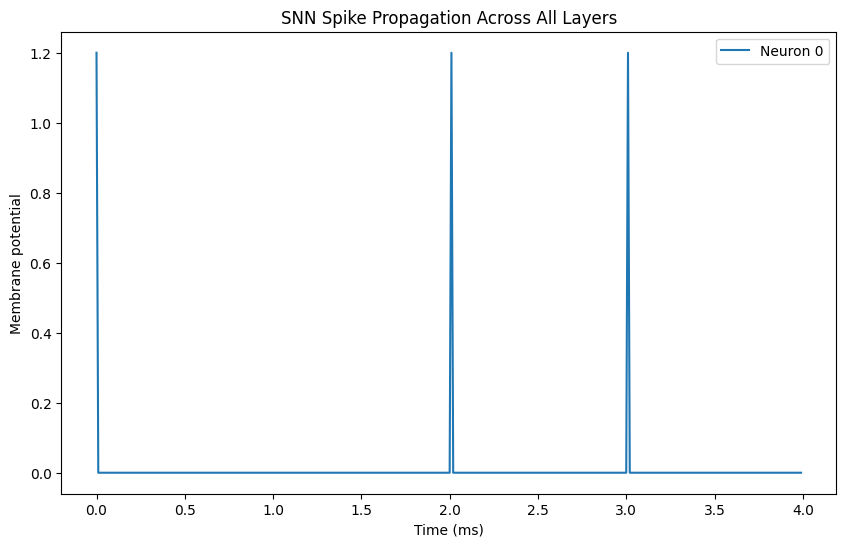

Neuron 0 spike times: ['0.000 ms', '2.010 ms', '3.010 ms']


In [25]:
# V0.1 Single Neruon for Yggrasil for spiking inputs and tau

from brian2 import *
import numpy as np
import logging, warnings

start_scope()

defaultclock.dt = 0.01*ms  

#prefs.codegen.target = 'cython'
set_device('runtime')
warnings.filterwarnings('ignore', category=RuntimeWarning)  # check error later
np.seterr(over='ignore', under='ignore')
logging.getLogger('brian2').setLevel(logging.ERROR)



@implementation('numpy', discard_units=True)
@check_units(global_clock=1, tau_fire_time=1, spikes_fired=1, result=1)
def tau_fire(spikes_fired, tau_fire_time, global_clock):
    '''0 when not at tau time + fired_time 1 when it is v +=1.2 when it is true'''
    if spikes_fired == 2: 
        if global_clock > tau_fire_time - 0.01:  # can change the - to other value of time_steps
            return 1
    return 0


neurons = NeuronGroup(1, '''
        v : 1
        global_clock : 1
        spikes_fired : 1
        tau_fire_time : 1
                      
    ''', threshold='v > 1', reset='''
        v = 0
        spikes_fired += 1
    ''', method='exact') 
neurons.v = 1.2
#neurons.tau = 0.5
neurons.spikes_fired = 0
neurons.tau_fire_time = 4 # should be runtime to start 


stim = SpikeGeneratorGroup(1, indices=[0], times=[2.0] * ms)


syn_input = Synapses(stim, neurons[0:1], '''
''', on_pre='''
    v += 1.2
''')
syn_input.connect(j='i')  # connects linears 1-1 2-2 ect


syn_input_tau = Synapses(stim, neurons[0:1], '''
''', on_pre='''
    v += 1.2
''', delay=1*ms)
syn_input_tau.connect(j='i')  # connects linears 1-1 2-2 ect
# syn_input_tau.tau = 0.5
# syn_input_tau.delay = 0.5 * ms

#tau_fire_time = global_clock + tau


# v += (tau_fire(spikes_fired, tau_fire_time, global_clock) * 1.2)

neurons.run_regularly('''
    global_clock += 0.01
''', dt=0.01*ms)

mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
spikemon = SpikeMonitor(neurons)

run(4*ms)

    # Plot voltages
figure(figsize=(10, 6))
for i in range(1):  # All neurons
    plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Membrane potential')
legend()
title('SNN Spike Propagation Across All Layers')
show()

for i in range(1):
    times = spikemon.spike_trains()[i]
    if len(times) > 0:
        formatted_times = [f"{t/ms:.3f} ms" for t in times]
        print(f"Neuron {i} spike times: {formatted_times}")
